## Asymmetry, wind shear, and motion

See also notebook test_asymmetry_windshear.ipynb in parent directory. 

NB: Raffiner les fits du Holland en prenant une moving window de thetas. Is it really necessary? I don't think so!

NB: Proche du Rmax, il y a 2 bosses et 2 creux dans V(theta), i.e une asymétrie d'ordre WN2, ce qui fait que mon fit est mauvais et converge vers 0.1 m/s, i.e la borne inférieure. Je peux éliminer ces régions en comparant à la RMSE. Avec les figures, on voit que le WN2 domine dans l'inner-core. A partir de 1.5*Rmax, le WN1 domine. Donc on va pouvoir utiliser le WN1 pour calibrer Kepert pour r > Rmax.

CHECK: Traiter l'hémisphère Sud séparément (pas sûr de mon storm_dir_adjusted) ?

NB: Je ne peux pas checker la dépendance de (c1, c2) au motion/wind shear pour le modèle K25_wIA car je n'ai pas assez de cas. Revoir ça une fois que j'ai enelevé mon filtre storm motion > wind shear.

Rappel: Downshear = in the direction of the vertical wind shear vector.

In [54]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Paths & Params
PTHS = {
    'dsg_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/02_ASYMM_SHEAR_MOTION/',
}

# PRMS = {
#     'sav_fgs': True
# }

In [3]:
# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

In [4]:
#########################
### General functions ###
#########################
def initialize_radius(spdm):
    '''Given the spdm, returns the largest radius (and asociated spdm) on which the profile can be fitted. 
    Indeed, sometimes the spdm isn't defined from r = 0 to r = 500, in this case the largest domain is taken instead.'''
    # Initialize first and last indexes
    first_valid_index = 0
    last_valid_index  = len(spdm)
    r                 = np.arange(last_valid_index) # to avoid having both r = 0 and n < 0 during fitting process
    
    ### Lower bound
    # We change it if spdm[0] = nan
    if np.isnan(spdm[0]):
        first_valid_index = np.min(np.where(np.isfinite(spdm)))
        
    ### Upper bound
    # We change it if there is a nan somewhere
    if np.isnan(np.min(spdm[first_valid_index:])):
        last_valid_index  = np.min(np.where(np.isnan(spdm[first_valid_index:]))[0]) # returns the index of the last valid value before the first nan
        last_valid_index += first_valid_index - 1
        
    # Define r and spdm
    r    = r[first_valid_index:last_valid_index] * 1000
    spdm = spdm[first_valid_index:last_valid_index]
    
    return r, spdm

def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def wn1(thetas, a, phi, c):
    return a * np.cos(thetas + phi) + c

def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, initial_condition],
        bounds=([1., -2 * np.pi, 0.1], [upper_bound, 2 * np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#########################
###       PLOT        ###
#########################
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  = 0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

palette = '/home/arthur/scripts/tools/high_wind_speed.pal'
cwnd         = getColorMap(rgbFile=palette)
normalizer   = Normalize(0, 80)

In [5]:
#########################
###  HYPERPARAMETERS  ###
#########################
### Reference grids
dim_ref      = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000 # to create cartesian dataset
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)                          # to create cartesian dataset
rs           = np.linspace(100, 5e5, 5000)    # Symetric
xs           = np.linspace(1000, 250000, 250) # Asymetric

### Compute asymmetry by computing an average Holland per theta slice to smooth all the noise
BDS_HOL = {
    'B':      [0.01, 3.],
    'Vmin':   [0, 50],
    'Rmax':   [5 * 1000, 500 * 1000],
    'Vmax':   [10, 100],   
}
# Define the steps
th_steps = np.linspace(0, 360, 19)[:-1] # Slice of 20 degrees
th_delta = 20 # degrees

In [6]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 10) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20) & 
    (dsg.dist2coast > dsg.r34)
)
d    = dsg.where(cond, drop=True)
print(len(d.time))

411


### Compute asymmetry

In [7]:
L_FIL = []
TIMES = []
L_ERR = []
L_VTS = []
L_ACN = []
L_PHS = []

for t in tqdm(range(len(d.time))):
    ### Open
    ds  = d.isel(time=t)
    dsp = xr.open_dataset(PTHS['sar_dir'] + ds.file_tcva.item()).isel(time=0)

    ###########################
    ### Compute asymmetries ###
    ###########################

    ### Compute asymmetries using Holland
    # Initialize
    LWS = [] # To save the Holland wind speeds
    VTS = [] # Nb of valid thetas
    ERR = [] # Error of fit - WN1
    ACN = [] # Amplitude of cosine using Holland - WN1
    PHS = [] # Phase of cosine using Holland - WN1
    
    # Fit Holland for each azimuthal slice
    for th in th_steps:
        # Open SAR azimuthal slice to fit Holland
        ds_slice          = dsp.sel(theta=slice(th, th + th_delta))
        wsm               = ds_slice.wind_speed.mean(dim='theta', skipna=True)
        r_crop, spdm_crop = initialize_radius(np.array(wsm))
        try:
            # Holland
            popt, pcov = curve_fit(
                lambda r, B, Vmin, Rmax, Vmax: holland_profile(r, float(abs(ds.lat)), B, Vmin, Rmax, Vmax), 
                np.array(r_crop), 
                np.array(spdm_crop), 
                p0=[1.8, 5, 20 * 1000, 40], 
                bounds=(
                    tuple([BDS_HOL[e][0] for e in BDS_HOL.keys()]), # NB: lat is fixed
                    tuple([BDS_HOL[e][1] for e in BDS_HOL.keys()])
                ) 
            ) 
            B_hol, vmn_hol, rmx_hol, vmx_hol = popt
        except RuntimeError:
            B_hol = vmn_hol = rmx_hol = vmx_hol = np.nan
        # Append
        LWS.append(holland_profile(rs, float(abs(ds.lat)), B_hol, vmn_hol, rmx_hol, vmx_hol))
        
    # Create dataset structure
    dsh = xr.Dataset(
        data_vars={
            'ws':        (('th', 'rad'), LWS),
        },
        coords={
            'th': th_steps,
            'rad': rs,
        }
    )
    
    # Compute Asymmetries
    for rad in xs:
        # Open SAR azimuthal wind distrib just to compute nb of valid thetas and compute errors
        valid_dsp         = dsp.sel(rad=rad, method='nearest').dropna(subset=['wind_speed'], dim='theta')
        # WN1
        acn_hol1, phi_hol1, c_hol1 = get_wn1(np.deg2rad(dsh.sel(rad=rad, method='nearest').dropna(subset=['ws'], dim='th').th), dsh.sel(rad=rad, method='nearest').dropna(subset=['ws'], dim='th').ws, float(ds.vmx) / 3, float(ds.vmx))
        # Error
        error1                     = float(rmse(wn1(np.deg2rad(valid_dsp.theta), acn_hol1, phi_hol1, c_hol1), valid_dsp.wind_speed))
        # Append
        VTS.append(len(valid_dsp.theta))
        ERR.append(error1)
        ACN.append(acn_hol1)
        PHS.append(phi_hol1)
    
    ### Append
    L_FIL.append(ds.file_tcva.item())
    TIMES.append(ds.time.data)
    L_VTS.append(VTS)
    L_ERR.append(ERR)
    L_ACN.append(ACN)
    L_PHS.append(PHS)

  0%|          | 0/411 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
# Concatenate into a single dataset
dsa_raw = xr.Dataset(
    data_vars={
        'acn':       (('time', 'rad'), L_ACN),
        'phs':       (('time', 'rad'), L_PHS),
        'err':       (('time', 'rad'), L_ERR),
        'vts':       (('time', 'rad'), L_VTS),
        'file_tcva': ('time', L_FIL),
    },
    coords={
        'time': TIMES,
        'rad': xs
    }
)

In [ ]:
# # Eventually save
# dsa_raw.to_netcdf(PTHS['sav_dir'] + 'dsa.nc')

In [7]:
# # Eventually load
# dsa_raw = xr.open_dataset(PTHS['sav_dir'] + 'dsa.nc')

### 1) Diagnostics - Relationship between storm motion and wind shear

Text(0, 0.5, 'Counts')

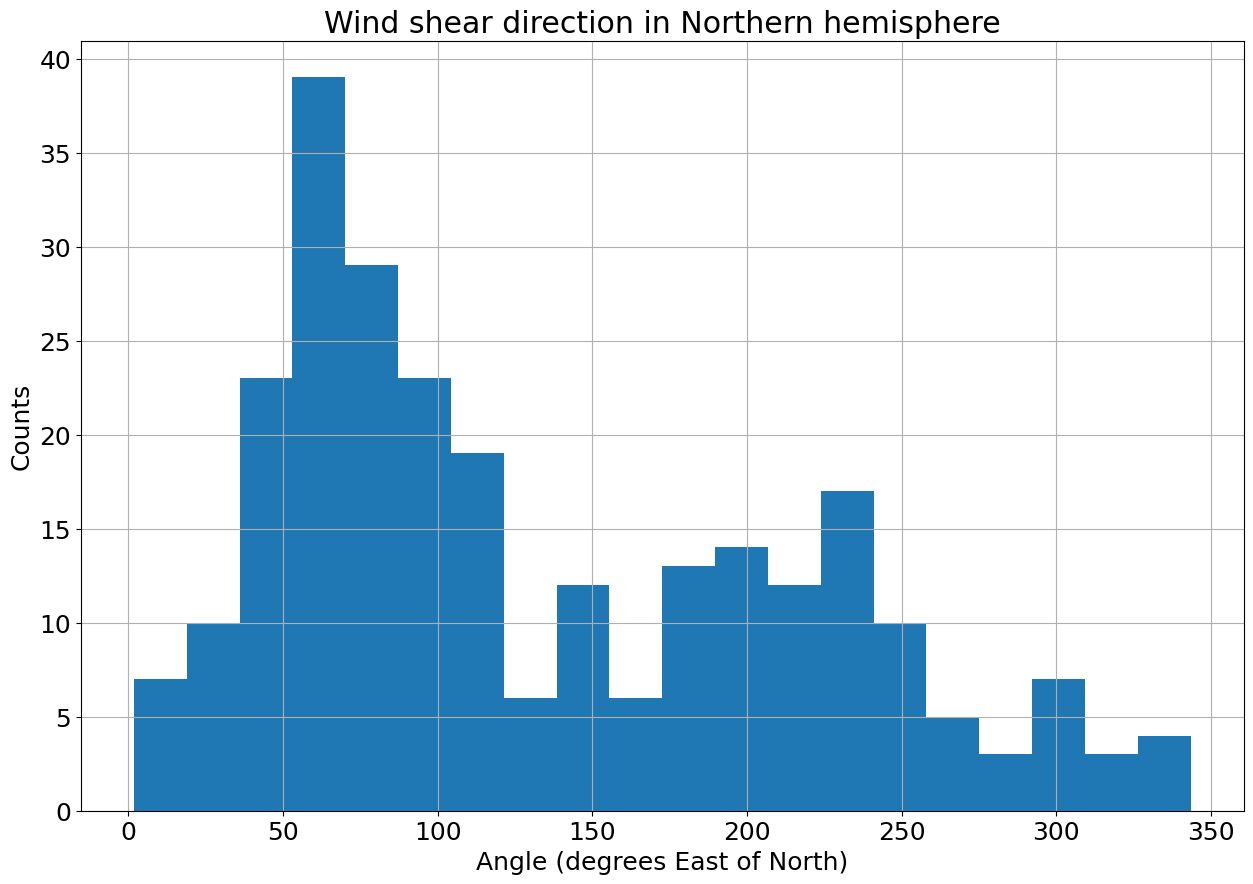

In [8]:
plt.title('Wind shear direction in Northern hemisphere')
plt.hist(d.where(d.lat > 0, drop=True).wsd_pmd, bins=20)
plt.grid()
plt.xlabel('Angle (degrees East of North)')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

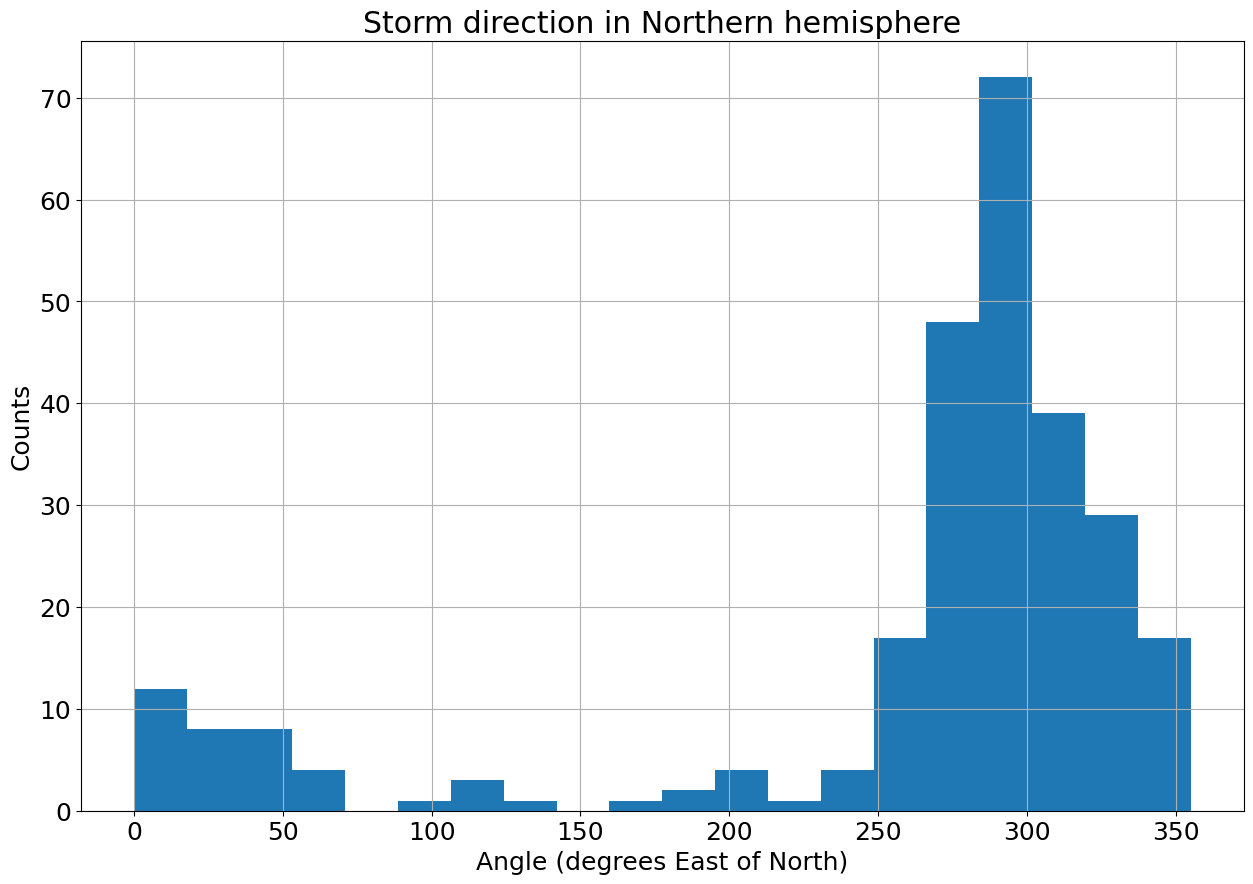

In [9]:
plt.title('Storm direction in Northern hemisphere')
plt.hist(d.where(d.lat > 0, drop=True).storm_dir_ibt, bins=20)
plt.grid()
plt.xlabel('Angle (degrees East of North)')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

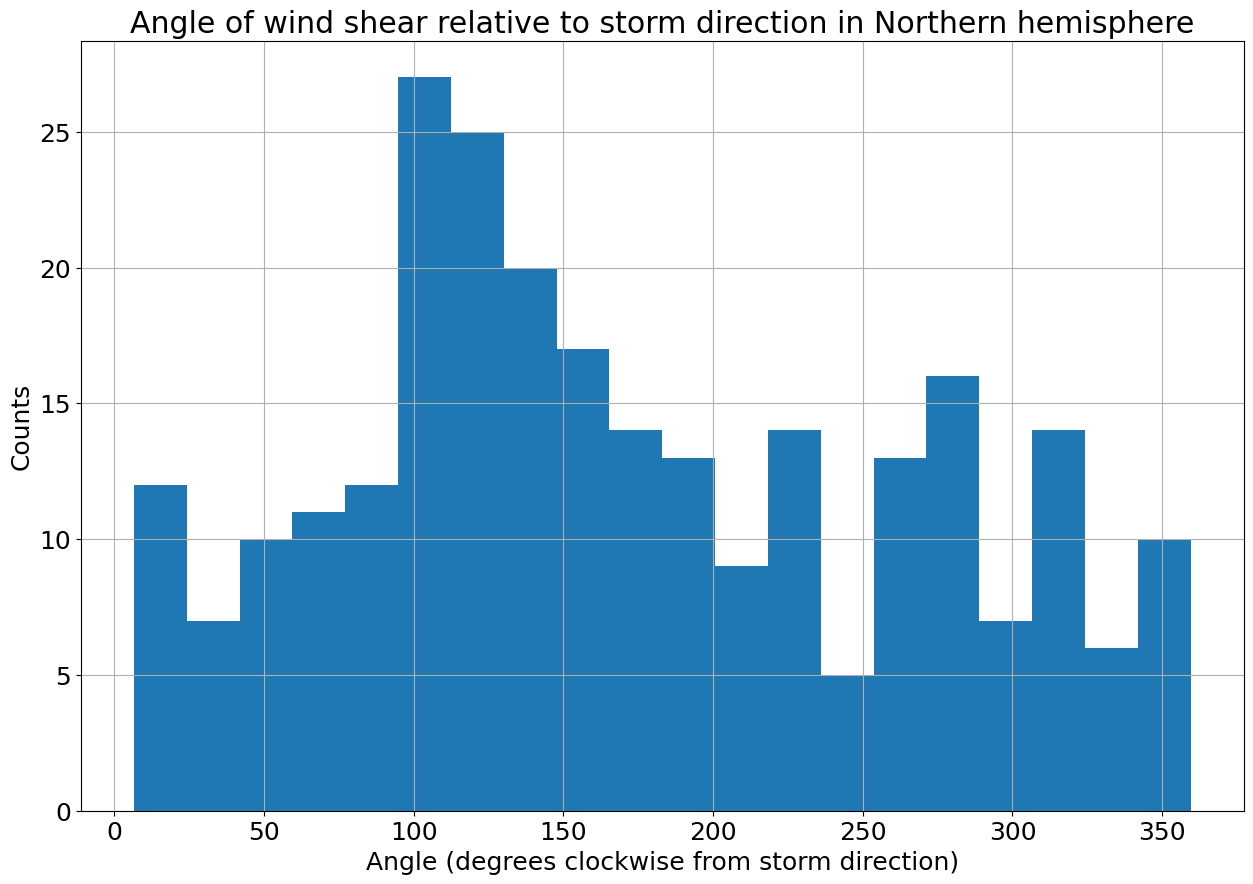

In [10]:
plt.title('Angle of wind shear relative to storm direction in Northern hemisphere')
plt.hist((d.where(d.lat > 0, drop=True).wsd_pmd - d.where(d.lat > 0, drop=True).storm_dir_ibt) % 360, bins=20)
plt.grid()
plt.xlabel('Angle (degrees clockwise from storm direction)')
plt.ylabel('Counts')

In [11]:
print(len(d.where((d.where(d.lat > 0, drop=True).wsd_pmd - d.where(d.lat > 0, drop=True).storm_dir_ibt) % 360 < 180, drop=True).time))
print(len(d.where(d.lat > 0, drop=True).time))
print('In the Northern Hemisphere, {:.1f}% of the cases have a left-of-shear motion. Corbosiero and Molinari 2003 found 78% in the North Atlantic.'.format((151 / 271) * 100))

151
271
In the Northern Hemisphere, 55.7% of the cases have a left-of-shear motion. Corbosiero and Molinari 2003 found 78% in the North Atlantic.


In [12]:
print(len(d.where((d.where((d.lat > 0) & (d.id.str[:2] == 'al'), drop=True).wsd_pmd - d.where((d.lat > 0) & (d.id.str[:2] == 'al'), drop=True).storm_dir_ibt) % 360 < 180, drop=True).time))
print(len(d.where((d.lat > 0) & (d.id.str[:2] == 'al'), drop=True).time))
print('In the North Atlantic, {:.1f}% of the cases have a left-of-shear motion. Corbosiero and Molinari 2003 found 78% in the North Atlantic.'.format((48 / 60) * 100))

48
60
In the North Atlantic, 80.0% of the cases have a left-of-shear motion. Corbosiero and Molinari 2003 found 78% in the North Atlantic.


Text(0, 0.5, 'Counts')

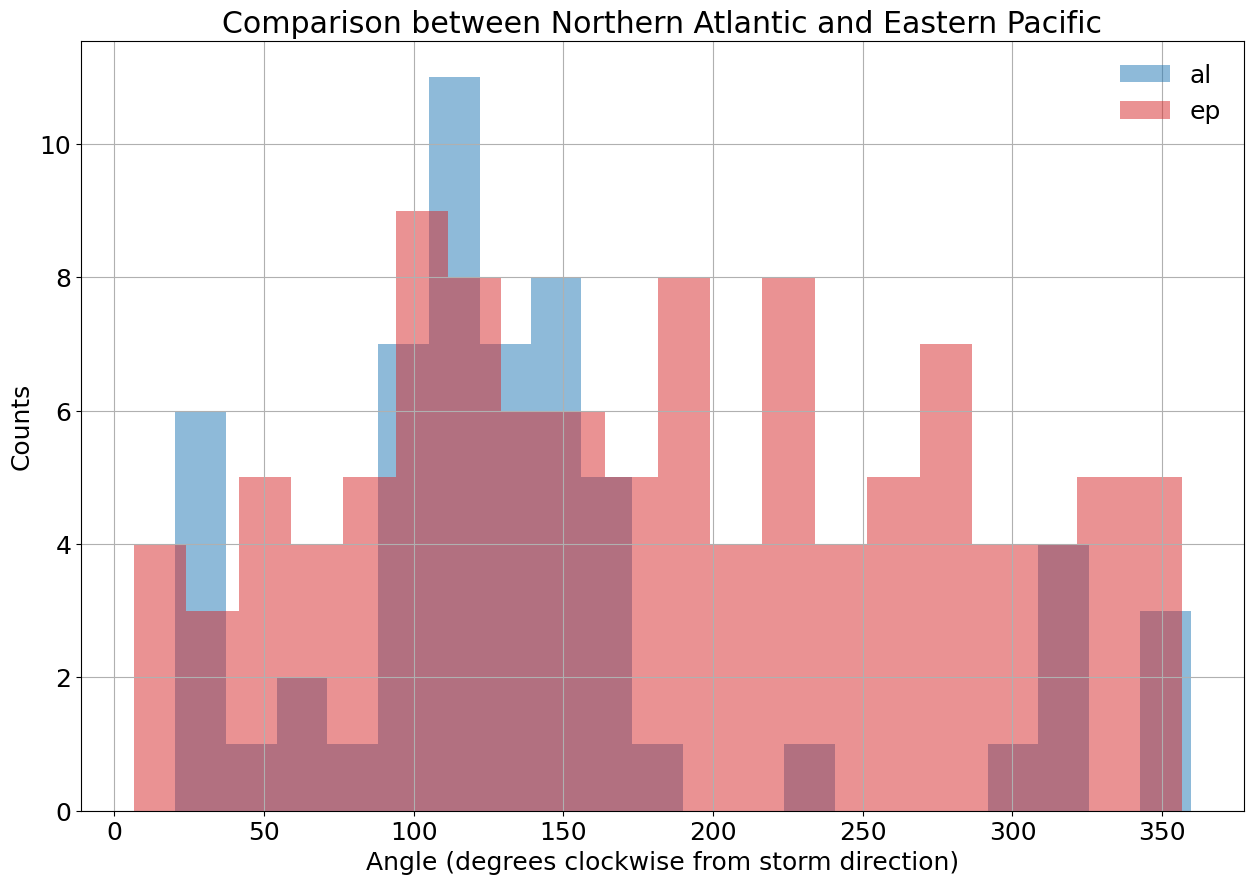

In [13]:
plt.title('Comparison between Northern Atlantic and Eastern Pacific')
plt.hist((d.where(d.id.str[:2] == 'al', drop=True).wsd_pmd - d.where(d.id.str[:2] == 'al', drop=True).storm_dir_ibt) % 360, label='al', color='tab:blue', bins=20, alpha=0.5)
plt.hist((d.where(d.id.str[:2] == 'ep', drop=True).wsd_pmd - d.where(d.id.str[:2] == 'ep', drop=True).storm_dir_ibt) % 360, label='ep', color='tab:red',  bins=20, alpha=0.5)
plt.grid()
plt.legend(frameon=False)
plt.xlabel('Angle (degrees clockwise from storm direction)')
plt.ylabel('Counts')

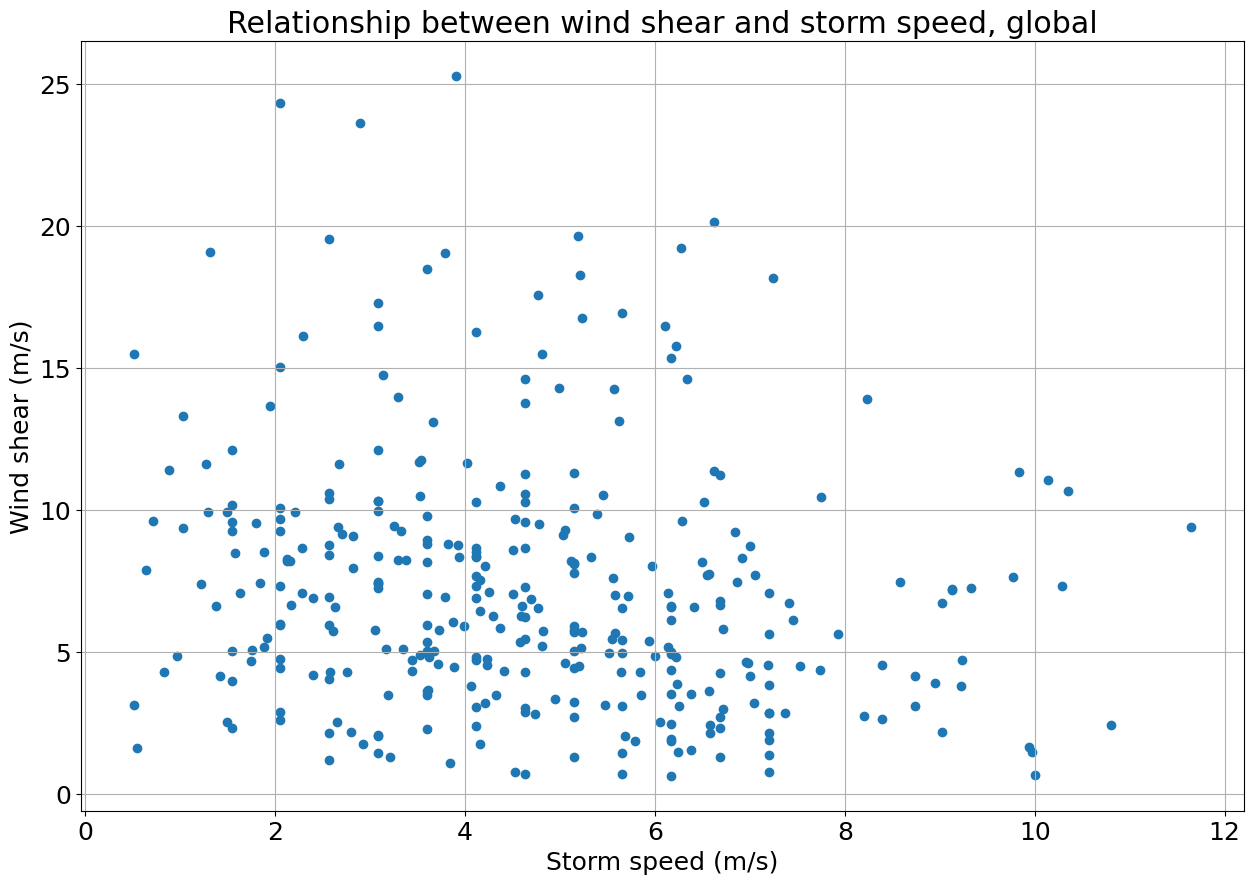

In [14]:
plt.title('Relationship between wind shear and storm speed, global')
plt.scatter(d.storm_speed_ibt, d.vws_pmd)
plt.xlabel('Storm speed (m/s)')
plt.ylabel('Wind shear (m/s)')
plt.grid()

### 2) Diagnostics - SAR surface wind asymmetries

#### Asymmetry profiles

In [15]:
# Reference grid
r_star = np.linspace(0, 16, 16 * 8 + 1)
# r_star = np.linspace(0, 16, 321)
# print(r_star)

In [16]:
# Merge with SAR info
dsa        = xr.merge([d.sel(time=dsa_raw.time), dsa_raw], join="inner")

# Update Southern hemisphere storms
dsa['storm_dir_adjusted']               = dsa['storm_dir_ibt'].copy(deep=True) # No change as I am not sure, just remove SH storms
# dsa['storm_dir_adjusted'][dsa.lat < 0] += 180

# Transform r into r*
dsa['rad'] = dsa['rad'] / dsa.rmx
l_dsa_     = []
for t in tqdm(range(len(dsa.time))):
    l_dsa_.append(dsa.isel(time=t).interp(rad=r_star))
dsa_ = xr.concat(l_dsa_, dim='time')

# FILTERS
keep = (
    # (dsa_.vts == 360)  
    (dsa_.lat > 0) 
    # (dsa.vmx > 33)
)
dsa_['keep'] = keep

  0%|          | 0/411 [00:00<?, ?it/s]

4.864419268930421
4.789576179107954
4.685102540164494
4.342697556946029


(0.0, 10.0)

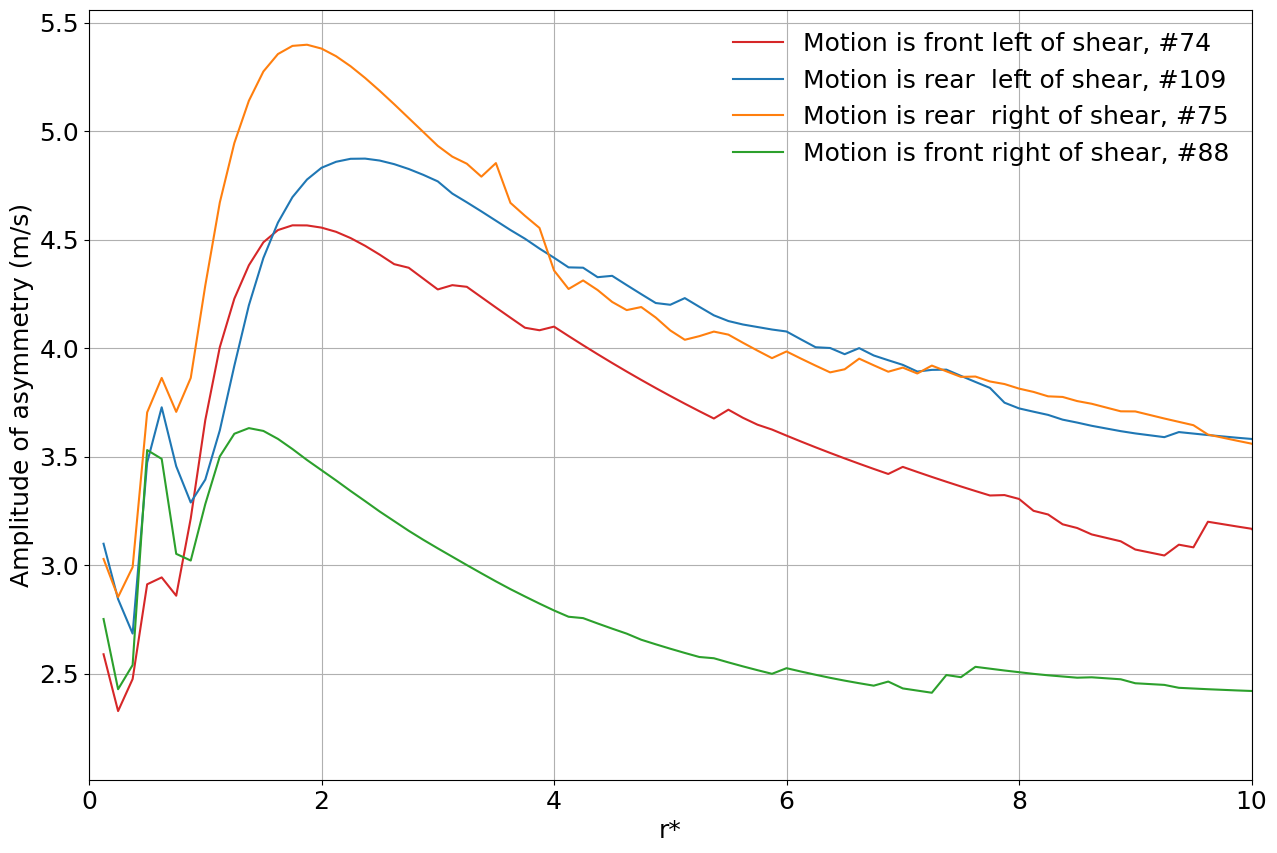

In [17]:
# dsa1_ = dsa_.where(((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 >= 0)   & ((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 <= 90),  drop=True).where(~np.isnan(dsa_.vws_pmd)).dropna(dim='time', subset=['vws_pmd'])
# dsa2_ = dsa_.where(((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 >= 90)  & ((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 <= 180), drop=True).where(~np.isnan(dsa_.vws_pmd)).dropna(dim='time', subset=['vws_pmd'])
# dsa3_ = dsa_.where(((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 >= 180) & ((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 <= 270), drop=True).where(~np.isnan(dsa_.vws_pmd)).dropna(dim='time', subset=['vws_pmd'])
# dsa4_ = dsa_.where(((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 >= 270) & ((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 <= 360), drop=True).where(~np.isnan(dsa_.vws_pmd)).dropna(dim='time', subset=['vws_pmd'])

dsa1_ = dsa_.where(((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 >= 0)   & ((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 <= 90),  drop=True)
dsa2_ = dsa_.where(((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 >= 90)  & ((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 <= 180), drop=True)
dsa3_ = dsa_.where(((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 >= 180) & ((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 <= 270), drop=True)
dsa4_ = dsa_.where(((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 >= 270) & ((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 <= 360), drop=True)

# print(float(dsa1.rmx.mean()))
# print(float(dsa2.rmx.mean()))
# print(float(dsa3.rmx.mean()))
# print(float(dsa4.rmx.mean()))

print(float(dsa1_.storm_speed_ibt.mean()))
print(float(dsa2_.storm_speed_ibt.mean()))
print(float(dsa3_.storm_speed_ibt.mean()))
print(float(dsa4_.storm_speed_ibt.mean()))

plt.plot(r_star, dsa1_.acn.where(dsa1_.keep).mean(dim='time'), label='Motion is front left of shear, #{}'.format(len(dsa1_.time)),  c='tab:red')
plt.plot(r_star, dsa2_.acn.where(dsa2_.keep).mean(dim='time'), label='Motion is rear  left of shear, #{}'.format(len(dsa2_.time)),  c='tab:blue')
plt.plot(r_star, dsa3_.acn.where(dsa3_.keep).mean(dim='time'), label='Motion is rear  right of shear, #{}'.format(len(dsa3_.time)), c='tab:orange')
plt.plot(r_star, dsa4_.acn.where(dsa4_.keep).mean(dim='time'), label='Motion is front right of shear, #{}'.format(len(dsa4_.time)), c='tab:green')
plt.legend(frameon=False)
plt.grid()
plt.xlabel('r*')
plt.ylabel('Amplitude of asymmetry (m/s)')

plt.xlim(0, 10)

(0.0, 10.0)

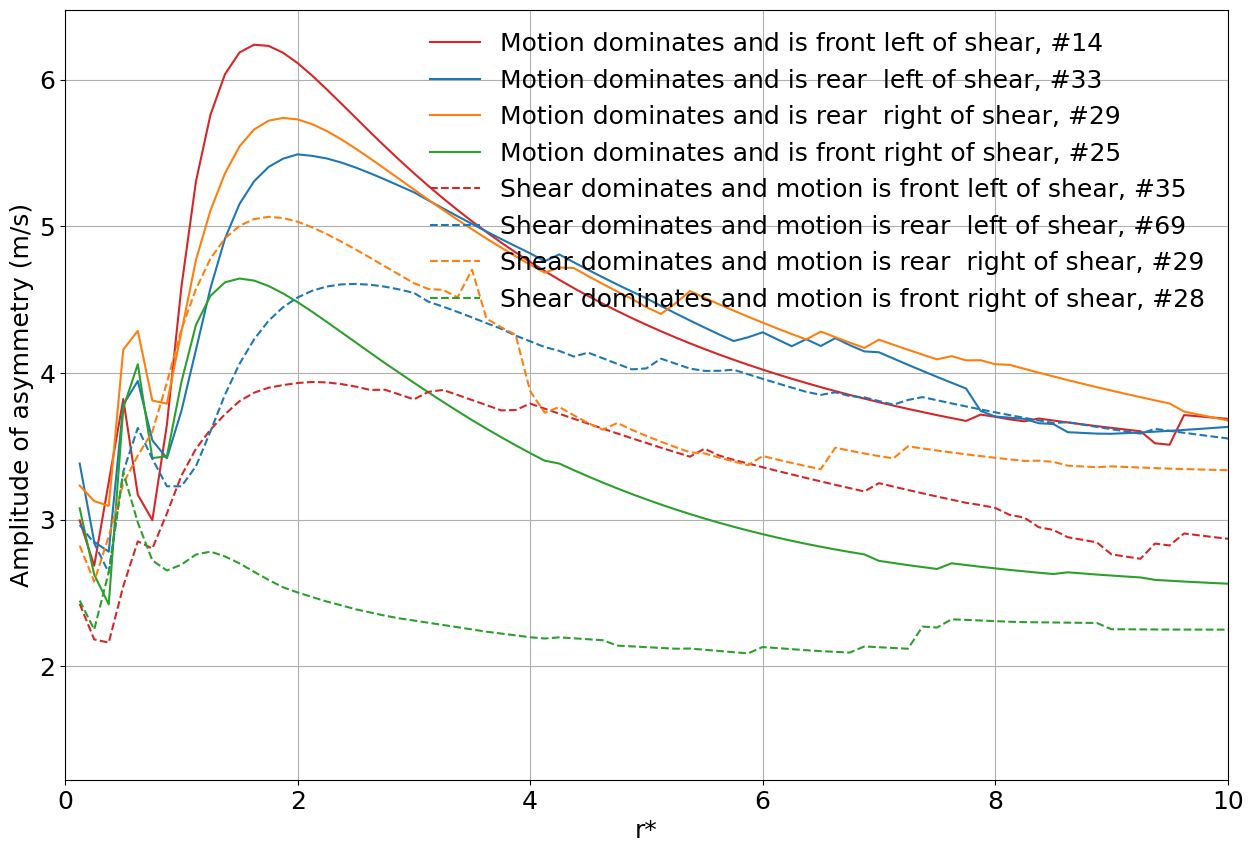

In [18]:
dsa1_ = dsa_.where(((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 >= 0)   & ((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 <= 90),  drop=True)
dsa2_ = dsa_.where(((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 >= 90)  & ((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 <= 180), drop=True)
dsa3_ = dsa_.where(((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 >= 180) & ((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 <= 270), drop=True)
dsa4_ = dsa_.where(((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 >= 270) & ((dsa_.wsd_pmd - dsa_.storm_dir_adjusted) % 360 <= 360), drop=True)

# Motion dominates
dsa1_mot = dsa1_.where((dsa1_.keep == 1) & (dsa1_.storm_speed_ibt > dsa1_.vws_pmd), drop=True)
dsa2_mot = dsa2_.where((dsa2_.keep == 1) & (dsa2_.storm_speed_ibt > dsa2_.vws_pmd), drop=True)
dsa3_mot = dsa3_.where((dsa3_.keep == 1) & (dsa3_.storm_speed_ibt > dsa3_.vws_pmd), drop=True)
dsa4_mot = dsa4_.where((dsa4_.keep == 1) & (dsa4_.storm_speed_ibt > dsa4_.vws_pmd), drop=True)
# Shear dominates
dsa1_shr = dsa1_.where((dsa1_.keep == 1) & (dsa1_.storm_speed_ibt <= dsa1_.vws_pmd), drop=True)
dsa2_shr = dsa2_.where((dsa2_.keep == 1) & (dsa2_.storm_speed_ibt <= dsa2_.vws_pmd), drop=True)
dsa3_shr = dsa3_.where((dsa3_.keep == 1) & (dsa3_.storm_speed_ibt <= dsa3_.vws_pmd), drop=True)
dsa4_shr = dsa4_.where((dsa4_.keep == 1) & (dsa4_.storm_speed_ibt <= dsa4_.vws_pmd), drop=True)

# Plot
plt.plot(r_star, dsa1_mot.acn.mean(dim='time'), label='Motion dominates and is front left of shear, #{}'.format(len(dsa1_mot.time)),  c='tab:red')
plt.plot(r_star, dsa2_mot.acn.mean(dim='time'), label='Motion dominates and is rear  left of shear, #{}'.format(len(dsa2_mot.time)),  c='tab:blue')
plt.plot(r_star, dsa3_mot.acn.mean(dim='time'), label='Motion dominates and is rear  right of shear, #{}'.format(len(dsa3_mot.time)), c='tab:orange')
plt.plot(r_star, dsa4_mot.acn.mean(dim='time'), label='Motion dominates and is front right of shear, #{}'.format(len(dsa4_mot.time)), c='tab:green')

plt.plot(r_star, dsa1_shr.acn.mean(dim='time'), label='Shear dominates and motion is front left of shear, #{}'.format(len(dsa1_shr.time)), linestyle='dashed',  c='tab:red')
plt.plot(r_star, dsa2_shr.acn.mean(dim='time'), label='Shear dominates and motion is rear  left of shear, #{}'.format(len(dsa2_shr.time)), linestyle='dashed',  c='tab:blue')
plt.plot(r_star, dsa3_shr.acn.mean(dim='time'), label='Shear dominates and motion is rear  right of shear, #{}'.format(len(dsa3_shr.time)), linestyle='dashed', c='tab:orange')
plt.plot(r_star, dsa4_shr.acn.mean(dim='time'), label='Shear dominates and motion is front right of shear, #{}'.format(len(dsa4_shr.time)), linestyle='dashed', c='tab:green')

plt.legend(frameon=False)
plt.grid()
plt.xlabel('r*')
plt.ylabel('Amplitude of asymmetry (m/s)')

plt.xlim(0, 10)

#### Asymmetry location

In [19]:
# Compute phase of max. asymmetry
l_phs_max = []
for t in tqdm(range(len(dsa.time))):
    l_phs_max.append(float(dsa.isel(time=t).phs[dsa.isel(time=t).rad >= 1].isel(rad=dsa.isel(time=t).acn[dsa.isel(time=t).rad >= 1].argmax())))
dsa['phs_max'] = xr.DataArray(l_phs_max, coords={'time': dsa.time})

  0%|          | 0/411 [00:00<?, ?it/s]

In [142]:
# dsa_mot = dsa.where((dsa_.storm_speed_ibt > dsa_.vws_pmd) & keep, drop=True)
# dsa_shr = dsa.where((dsa_.storm_speed_ibt < dsa_.vws_pmd) & keep, drop=True)

# plt.scatter(
#     (dsa_mot.storm_dir_adjusted - dsa_mot.wsd_pmd) % 360, \
#     np.rad2deg(dsa_mot.phs_max) % 360,\
#     c='k', 
#     label='Motion > shear'
# )

# plt.scatter(
#     (dsa_shr.storm_dir_adjusted - dsa_shr.wsd_pmd) % 360, \
#     np.rad2deg(dsa_shr.phs_max) % 360,\
#     marker='*',
#     s=80, 
#     c=dsa_shr.storm_speed_ibt / dsa_shr.vws_pmd,
#     cmap=plt.get_cmap('coolwarm'),
#     vmin=0,
#     vmax=1, 
#     label='Shear > motion'
# )


# plt.colorbar(label='Ratio of storm motion to vertical wind shear amplitudes')
# plt.grid()
# plt.xlabel('Relative direction between storm motion and vertical wind shear vectors (°)')
# plt.ylabel('Relative direction of maximum asymmetry amplitude relative to storm motion vector (°)')
# plt.legend(frameon=True)

# # plt.scatter(
# #     (dsa_shr.wsd_pmd - dsa_shr.storm_dir_adjusted) % 360, \
# #     np.rad2deg(dsa_shr.phs_max) % 360,\
# #     c=dsa_shr.t_since_lmi_ibt / 3600,
# #     cmap=plt.get_cmap('coolwarm'),
# #     vmin=-72,
# #     vmax=72
# # )




In [143]:
# # Plotting params
# ticks = [-180, -90, 0, 90, 180]

# # Groups
# dsa_mot = dsa.where((dsa_.storm_speed_ibt > dsa_.vws_pmd) & keep, drop=True)
# dsa_shr = dsa.where((dsa_.storm_speed_ibt < dsa_.vws_pmd) & keep, drop=True)

# # Motion dominates over shear
# relShrDir_mot = (dsa_mot.wsd_pmd - dsa_mot.storm_dir_adjusted) % 360
# plt.scatter(
#     xr.where(np.rad2deg(dsa_mot.phs_max) < 180, np.rad2deg(dsa_mot.phs_max), np.rad2deg(dsa_mot.phs_max) - 360),\
#     xr.where(relShrDir_mot < 180, relShrDir_mot, relShrDir_mot - 360), \
#     c='k', 
#     label='Motion > shear'
# )

# # Shear dominates over motion
# relShrDir_shr = (dsa_shr.wsd_pmd - dsa_shr.storm_dir_adjusted) % 360
# plt.scatter(
#     xr.where(np.rad2deg(dsa_shr.phs_max) < 180, np.rad2deg(dsa_shr.phs_max), np.rad2deg(dsa_shr.phs_max) - 360),\
#     xr.where(relShrDir_shr < 180, relShrDir_shr, relShrDir_shr - 360), \
#     marker='*',
#     s=80, 
#     c=dsa_shr.storm_speed_ibt / dsa_shr.vws_pmd,
#     cmap=plt.get_cmap('coolwarm'),
#     vmin=0,
#     vmax=1, 
#     label='Shear > motion'
# )

# plt.axvline(c='k', linewidth=3)
# plt.axhline(c='k', linewidth=3)


# plt.colorbar(label='Ratio of storm motion to vertical wind shear amplitudes')
# # plt.grid()
# plt.xlabel('Azimuth of max. wind relative to motion (°)')
# plt.ylabel('Shear direction relative to motion (°)')
# plt.legend(frameon=True)

# plt.xticks(ticks)
# plt.yticks(ticks)
# plt.xlim(-180, 180);plt.ylim(-180, 180)

# plt.minorticks_on() 
# plt.grid(which='major', linestyle='-', color='gray')
# plt.grid(which='minor', linestyle=':', color='gray')


# # plt.scatter(
# #     (dsa_shr.wsd_pmd - dsa_shr.storm_dir_adjusted) % 360, \
# #     np.rad2deg(dsa_shr.phs_max) % 360,\
# #     c=dsa_shr.t_since_lmi_ibt / 3600,
# #     cmap=plt.get_cmap('coolwarm'),
# #     vmin=-72,
# #     vmax=72
# # )

In [104]:
# plt.hist(xr.where(np.rad2deg(dsa.phs_max) < 180, np.rad2deg(dsa.phs_max), np.rad2deg(dsa.phs_max) - 360), bins=50)
# plt.grid()

In [92]:
# Groups
dsa_mot = dsa.where((dsa_.storm_speed_ibt > dsa_.vws_pmd) & keep, drop=True)
dsa_shr = dsa.where((dsa_.storm_speed_ibt < dsa_.vws_pmd) & keep, drop=True)

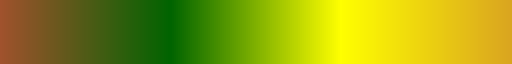

In [107]:
shr_colors = [
    'sienna',
    'darkgreen',
    'yellow',
    'goldenrod'
]

# Étape 2: Créer la colormap
shr_cmap = LinearSegmentedColormap.from_list(
    "cmap", shr_colors
)

shr_cmap

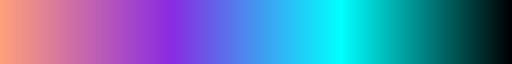

In [108]:
mot_colors = [
    'lightsalmon',
    'blueviolet',
    'cyan',
    'black'
]

# Étape 2: Créer la colormap
mot_cmap = LinearSegmentedColormap.from_list(
    "cmap", mot_colors
)

mot_cmap

In [115]:
# Step 1: Combine the data and define the full data range
all_data = np.concatenate([dsa_shr.storm_speed_ibt / dsa_shr.vws_pmd, dsa_mot.storm_speed_ibt / dsa_mot.vws_pmd])
vmin_full = 0
vmax_full = 4

# Step 2: Create a single, unified colormap
# We'll use the ratio of the range of each colormap to the total range
ratio_shr = 1 / (vmax_full - vmin_full) # Range 0-1
ratio_mot = (4 - 1) / (vmax_full - vmin_full) # Range 1-3

new_colors = np.vstack([
    shr_cmap(np.linspace(0, 1, int(ratio_shr * 256))), # Adjust for resolution
    mot_cmap(np.linspace(0, 1, int(ratio_mot * 256)))
])

# unified_cmap = LinearSegmentedColormap.from_list('unified_cmap', new_colors, N=256)
unified_cmap = LinearSegmentedColormap.from_list('unified_cmap', new_colors, N=16)

Text(-210, -135, 'Rear-left')

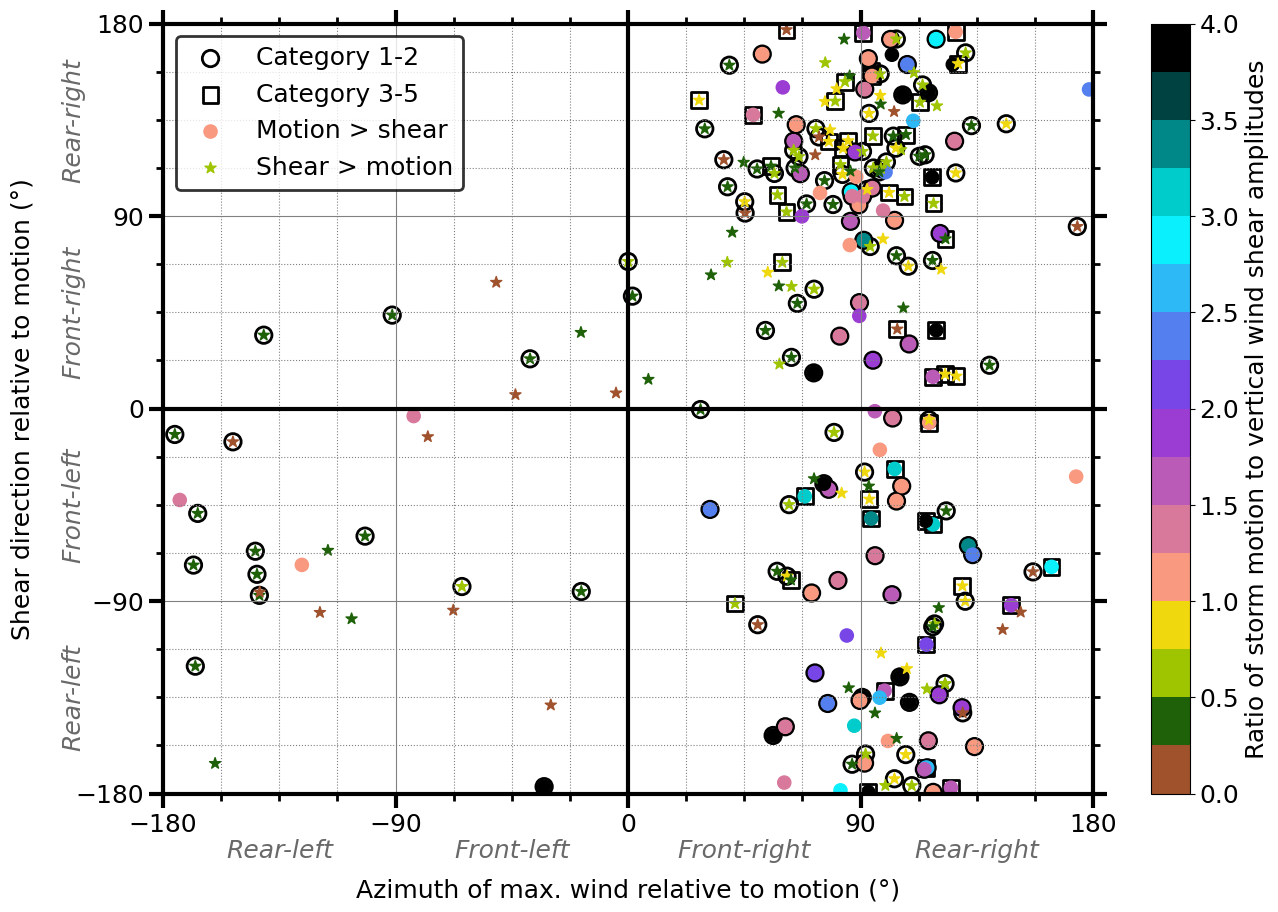

In [163]:
# Plotting params
ticks = [-180, -90, 0, 90, 180]


##################
### Add categories
# Create sub-datasets for each hurricane category
cat12 = dsa.where((dsa.vmx >= 33) & (dsa.vmx < 50) & keep, drop=True)
cat35 = dsa.where((dsa.vmx >= 50) & keep, drop=True)
# Category 1 and 2
plt.scatter(
    xr.where(np.rad2deg(cat12.phs_max) < 180, np.rad2deg(cat12.phs_max), np.rad2deg(cat12.phs_max) - 360),
    xr.where((cat12.wsd_pmd - cat12.storm_dir_adjusted) % 360 < 180, (cat12.wsd_pmd - cat12.storm_dir_adjusted) % 360, (cat12.wsd_pmd - cat12.storm_dir_adjusted) % 360 - 360),
    marker='o',  # Cercle
    facecolors='none',  # Pas de remplissage
    edgecolors='black', # Bordure noire
    linewidths=2,
    s=140, # Taille ajustée pour la visibilité
    label='Category 1-2'
)
# Category 3 and higher
plt.scatter(
    xr.where(np.rad2deg(cat35.phs_max) < 180, np.rad2deg(cat35.phs_max), np.rad2deg(cat35.phs_max) - 360),
    xr.where((cat35.wsd_pmd - cat35.storm_dir_adjusted) % 360 < 180, (cat35.wsd_pmd - cat35.storm_dir_adjusted) % 360, (cat35.wsd_pmd - cat35.storm_dir_adjusted) % 360 - 360),
    marker='s', # Carré
    facecolors='none',
    edgecolors='black',
    linewidths=2,
    s=130,
    label='Category 3-5'
)
### End categories
##################


# Motion dominates over shear
relShrDir_mot = (dsa_mot.wsd_pmd - dsa_mot.storm_dir_adjusted) % 360
plt.scatter(
    xr.where(np.rad2deg(dsa_mot.phs_max) < 180, np.rad2deg(dsa_mot.phs_max), np.rad2deg(dsa_mot.phs_max) - 360),\
    xr.where(relShrDir_mot < 180, relShrDir_mot, relShrDir_mot - 360), \
    c=dsa_mot.storm_speed_ibt / dsa_mot.vws_pmd, # Utiliser le ratio pour la couleur
    cmap=unified_cmap,  # Use the new colormap
    vmin=vmin_full,     # Use the full range
    vmax=vmax_full,
    s= 90,
    # edgecolors='black',  # Ajoute une bordure noire
    # linewidths=2,
    label='Motion > shear'
)

# Shear dominates over motion
relShrDir_shr = (dsa_shr.wsd_pmd - dsa_shr.storm_dir_adjusted) % 360
plt.scatter(
    xr.where(np.rad2deg(dsa_shr.phs_max) < 180, np.rad2deg(dsa_shr.phs_max), np.rad2deg(dsa_shr.phs_max) - 360),\
    xr.where(relShrDir_shr < 180, relShrDir_shr, relShrDir_shr - 360), \
    marker='*',
    s=70, 
    c=dsa_shr.storm_speed_ibt / dsa_shr.vws_pmd,
    cmap=unified_cmap,  # Use the new colormap
    vmin=vmin_full,     # Use the full range
    vmax=vmax_full,
    label='Shear > motion'
)

plt.axvline(c='k', linewidth=3)
plt.axhline(c='k', linewidth=3)

plt.colorbar(label='Ratio of storm motion to vertical wind shear amplitudes')
# plt.grid()
plt.xlabel('Azimuth of max. wind relative to motion (°)', labelpad=30)
plt.ylabel('Shear direction relative to motion (°)',      labelpad=30)

legend = plt.legend(frameon=True)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(2) # Ajustez l'épaisseur au besoin

plt.xticks(ticks)
plt.yticks(ticks)
plt.xlim(-180, 180);plt.ylim(-180, 180)

plt.minorticks_on() 
plt.grid(which='major', linestyle='-', color='gray')
plt.grid(which='minor', linestyle=':', color='gray')

# Change the appearance of the main plot frame
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')

# Turn on and style the top and right spines
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

# Set the tick parameters for all axes
ax.tick_params(which='major', width=3, length=10) # Set tick width and length for major ticks
ax.tick_params(which='minor', width=2, length=5) # Set tick width and length for minor ticks
ax.tick_params(axis='x', which='both', top=True) # Add ticks to the top x-axis
ax.tick_params(axis='y', which='both', right=True) # Add ticks to the right y-axis

# Ajouter les étiquettes de quadrants
# x-axis
ax.text(-135, -210, 'Rear-left',   ha='center', style='italic', color='dimgrey')
ax.text(-45,  -210, 'Front-left',  ha='center', style='italic', color='dimgrey')
ax.text(45,   -210, 'Front-right', ha='center', style='italic', color='dimgrey')
ax.text(135,  -210, 'Rear-right',  ha='center', style='italic', color='dimgrey')
# y-avis
ax.text(-210, 135,  'Rear-right',  ha='right', va='center', rotation=90, style='italic', color='dimgrey')
ax.text(-210, 45,   'Front-right', ha='right', va='center', rotation=90, style='italic', color='dimgrey')
ax.text(-210, -45,  'Front-left',  ha='right', va='center', rotation=90, style='italic', color='dimgrey')
ax.text(-210, -135, 'Rear-left',   ha='right', va='center', rotation=90, style='italic', color='dimgrey')


# plt.scatter(
#     (dsa_shr.wsd_pmd - dsa_shr.storm_dir_adjusted) % 360, \
#     np.rad2deg(dsa_shr.phs_max) % 360,\
#     c=dsa_shr.t_since_lmi_ibt / 3600,
#     cmap=plt.get_cmap('coolwarm'),
#     vmin=-72,
#     vmax=72
# )

# # Save
# plt.savefig(PTHS['sav_dir'] + 'asym_loc_SAR_max.png', bbox_inches='tight')

In [196]:
dsa_shr['azimLocMax'] = xr.where(np.rad2deg(dsa_shr.phs_max) < 180, np.rad2deg(dsa_shr.phs_max), np.rad2deg(dsa_shr.phs_max) - 360)
dsa_shr['relShrDir']  = xr.where(relShrDir_shr < 180, relShrDir_shr, relShrDir_shr - 360)

len_maxIsRightOfMot = len(dsa_shr.where((dsa_shr.azimLocMax > 0), drop=True).time)
len_maxIsFR_shrIsR  = len(dsa_shr.where((dsa_shr.azimLocMax > 0) & (dsa_shr.relShrDir > 0) & (dsa_shr.azimLocMax < 90), drop=True).time)
len_maxIsRR_shrIsR  = len(dsa_shr.where((dsa_shr.azimLocMax > 0) & (dsa_shr.relShrDir > 0) & (dsa_shr.azimLocMax > 90), drop=True).time)
len_maxIsFR_shrIsF  = len(dsa_shr.where((dsa_shr.azimLocMax > 0) & (dsa_shr.relShrDir < 0) & (dsa_shr.azimLocMax < 90), drop=True).time)
len_maxIsRR_shrIsF  = len(dsa_shr.where((dsa_shr.azimLocMax > 0) & (dsa_shr.relShrDir < 0) & (dsa_shr.azimLocMax > 90), drop=True).time)

print('{:.1f}% of the right-of-motion cases have a front-right maximum with a right-of-motion shear'.format((len_maxIsFR_shrIsR / len_maxIsRightOfMot) * 100))
print('{:.1f}% of the right-of-motion cases have a rear-right maximum with a right-of-motion shear'.format((len_maxIsRR_shrIsR / len_maxIsRightOfMot) * 100))
print('{:.1f}% of the right-of-motion cases have a front-right maximum with a left-of-motion shear'.format((len_maxIsFR_shrIsF / len_maxIsRightOfMot) * 100))
print('{:.1f}% of the right-of-motion cases have a rear-right maximum with a left-of-motion shear'.format((len_maxIsRR_shrIsF / len_maxIsRightOfMot) * 100))

39.3% of the right-of-motion cases have a front-right maximum with a right-of-motion shear
32.6% of the right-of-motion cases have a rear-right maximum with a right-of-motion shear
8.9% of the right-of-motion cases have a front-right maximum with a left-of-motion shear
19.3% of the right-of-motion cases have a rear-right maximum with a left-of-motion shear


#### Tests

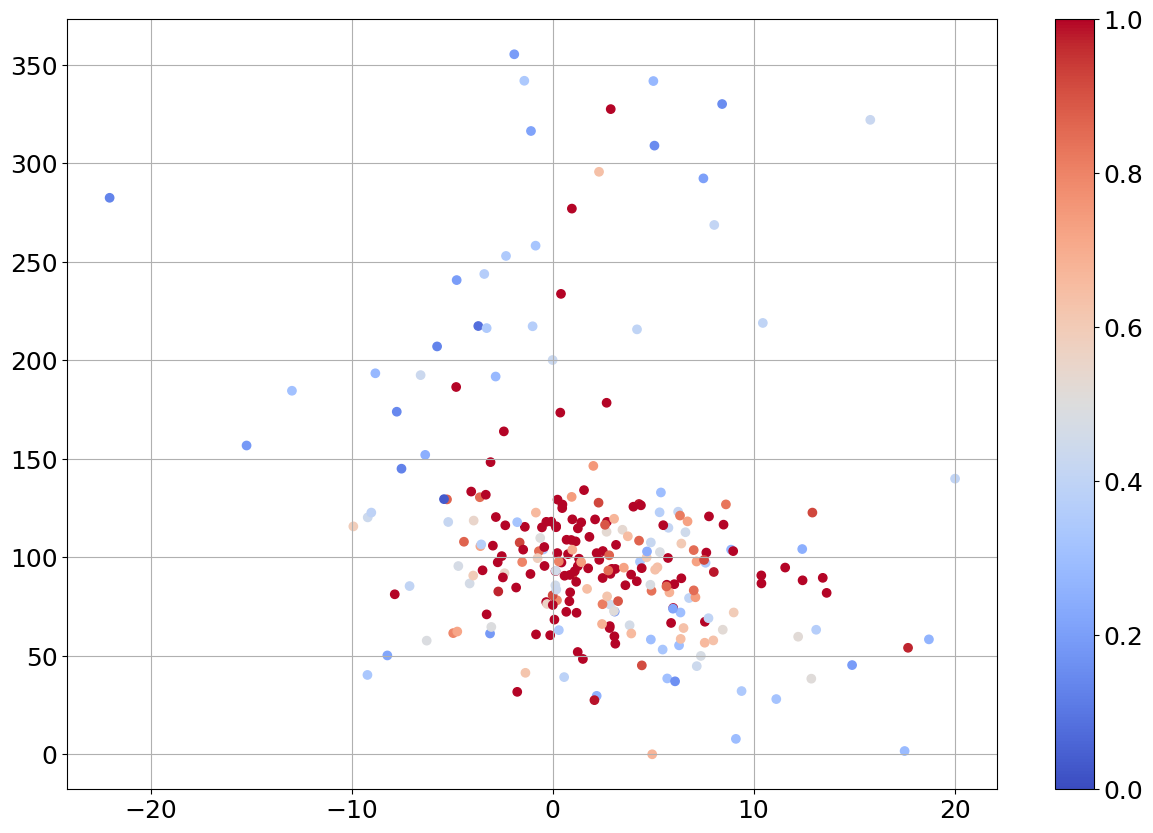

In [23]:
# Weighted contribution
dsa['wght_cont']   = dsa.storm_speed_ibt * np.cos(np.deg2rad(dsa.storm_dir_ibt)) + dsa.vws_pmd * np.cos(np.deg2rad(dsa.wsd_pmd))
plt.scatter(dsa.where(dsa_.keep).wght_cont, np.rad2deg(dsa.where(dsa_.keep).phs_max) % 360, c=dsa.storm_speed_ibt / dsa.vws_pmd,cmap=plt.get_cmap('coolwarm'),vmin=0,vmax=1, )
plt.grid()
plt.colorbar()

In [24]:
# Compute ampitude of max. asymmetry
l_acn_max = []
for t in tqdm(range(len(dsa.time))):
    l_acn_max.append(float(dsa.isel(time=t).acn[dsa.isel(time=t).rad >= 1].max()))
dsa['acn_max'] = xr.DataArray(l_acn_max, coords={'time': dsa.time})

  0%|          | 0/411 [00:00<?, ?it/s]

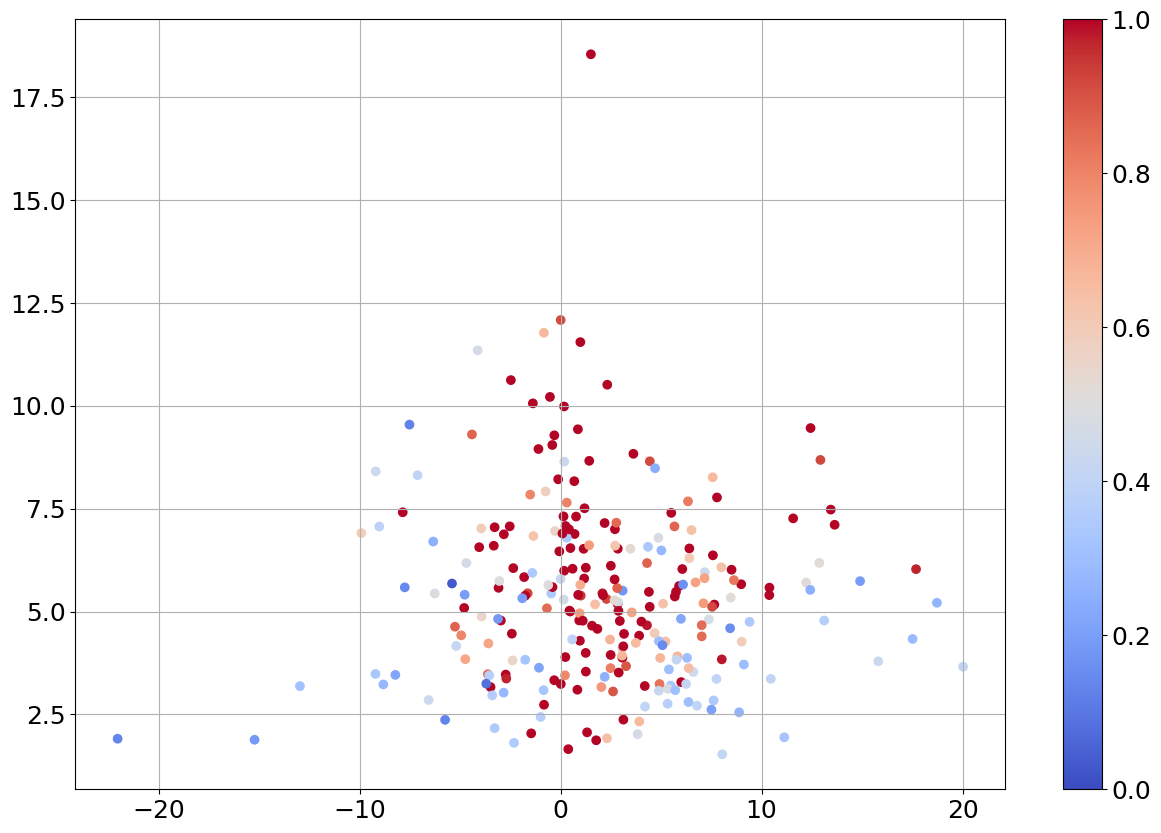

In [25]:
# Weighted contribution
plt.scatter(dsa.where(dsa_.keep).wght_cont, dsa.where(dsa_.keep).acn_max, c=dsa.storm_speed_ibt / dsa.vws_pmd,cmap=plt.get_cmap('coolwarm'),vmin=0,vmax=1, )
plt.grid()
plt.colorbar()

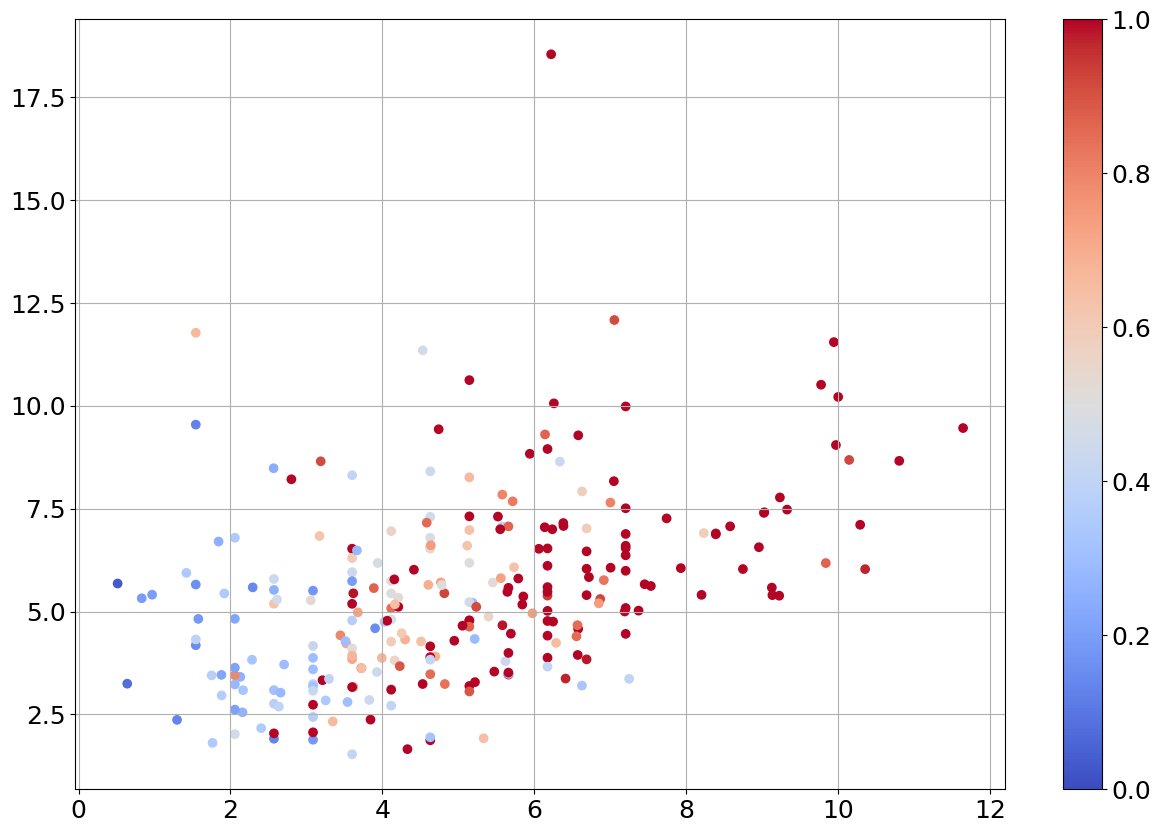

In [26]:
# Storm speed
plt.scatter(dsa.where(dsa_.keep).storm_speed_ibt, dsa.where(dsa_.keep).acn_max, c=dsa.storm_speed_ibt / dsa.vws_pmd,cmap=plt.get_cmap('coolwarm'),vmin=0,vmax=1, )
plt.grid()
plt.colorbar()

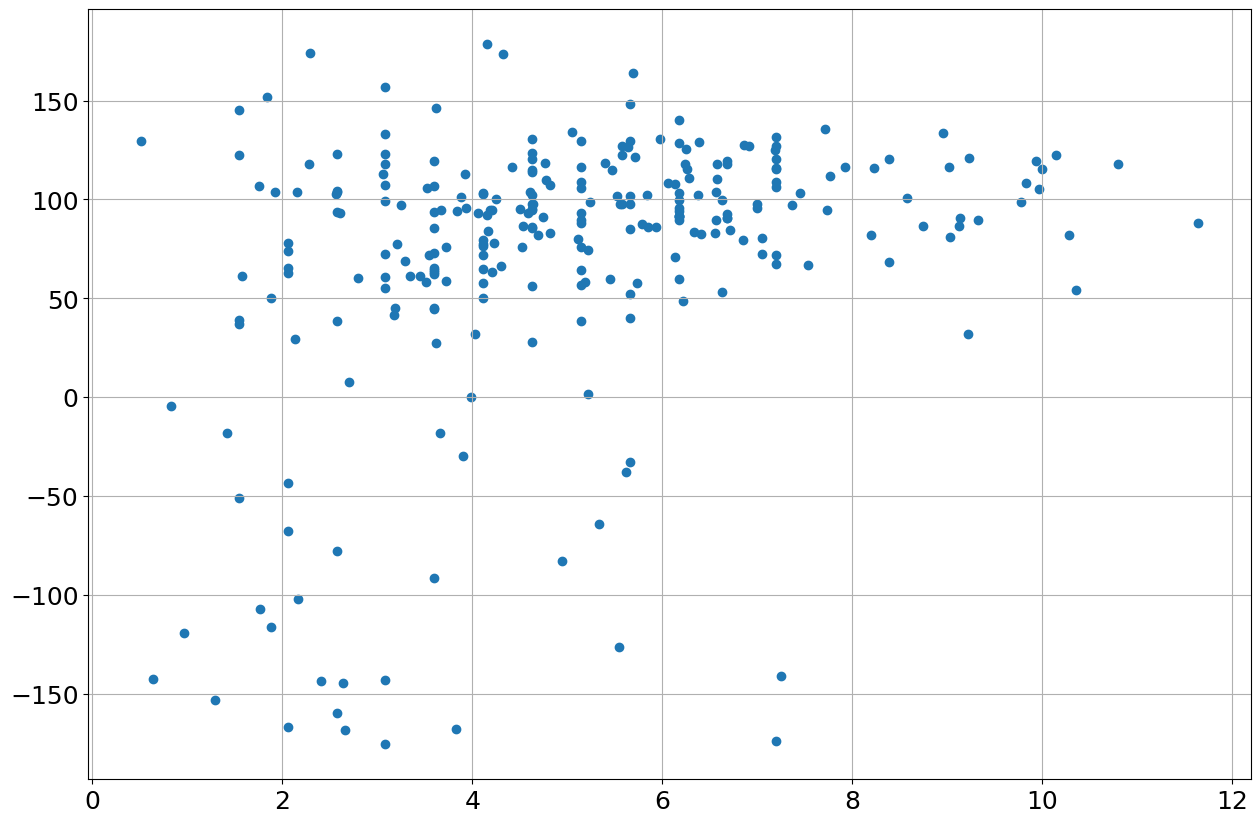

In [27]:
# Impact of storm speed magnitude on max. wind location
plt.scatter(dsa.where(dsa_.keep).storm_speed_ibt, xr.where(np.rad2deg(dsa.where(dsa_.keep).phs_max) < 180, np.rad2deg(dsa.where(dsa_.keep).phs_max), np.rad2deg(dsa.where(dsa_.keep).phs_max) - 360))
plt.grid()

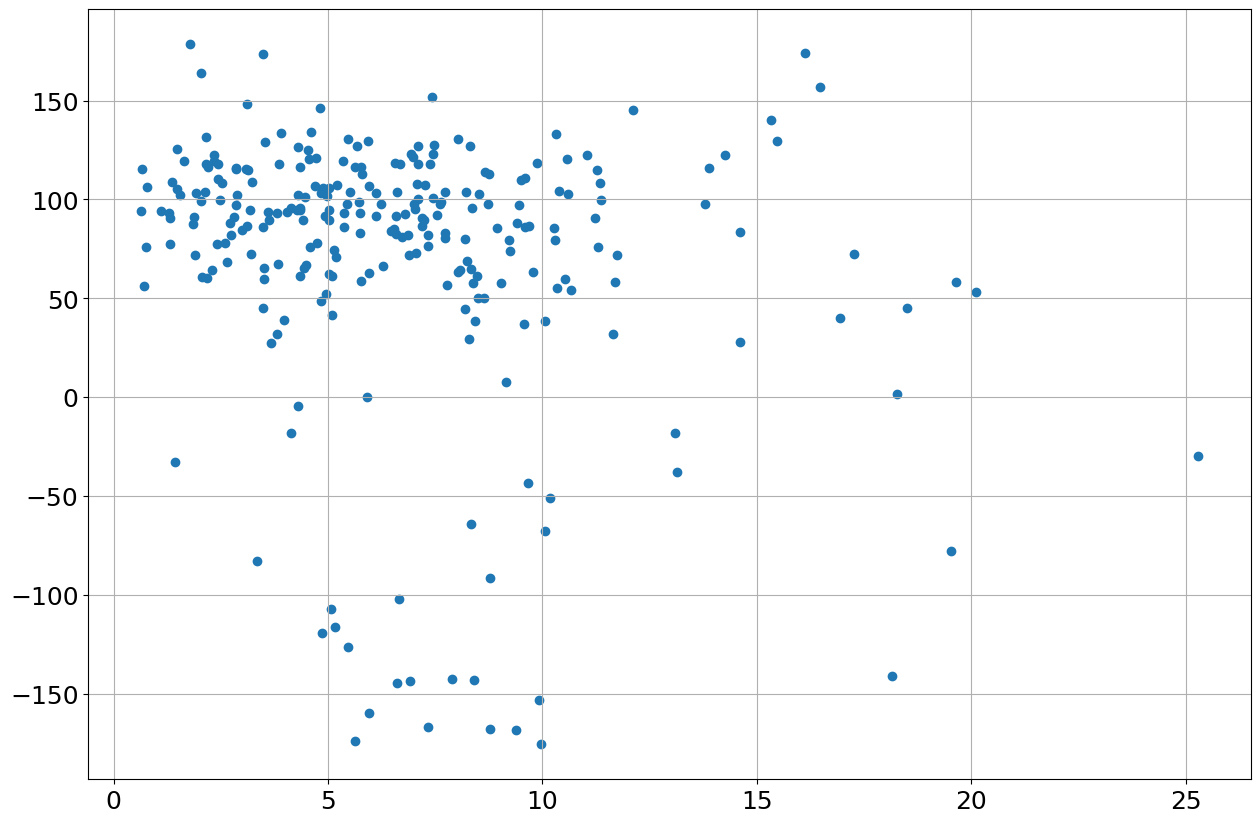

In [28]:
# Impact of vertical wind shear on max. wind location
plt.scatter(dsa.where(dsa_.keep).vws_pmd, xr.where(np.rad2deg(dsa.where(dsa_.keep).phs_max) < 180, np.rad2deg(dsa.where(dsa_.keep).phs_max), np.rad2deg(dsa.where(dsa_.keep).phs_max) - 360))
plt.grid()

In [ ]:
# for t in range(20):
#     dsa3_.isel(time=t).acn.plot()